In [1]:
import operator        
import datetime
import warnings
warnings.filterwarnings('ignore')
from itertools import product

import numpy as np
import pandas as pd

import seaborn as sns
# import pandas_profiling as pdf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, lars_path, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# pointer to scaler I want to use to easily swap scalers
use_transform = RobustScaler

import scipy
import scipy.stats as stats
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import autogluon as ag
from autogluon import TabularPrediction as task

#!conda install -y -conda-forge  xgboost 
# import xgboost
# from xgboost import XGBRegressor
# from xgboost import plot_importance

#!conda install -y -c conda-forge lightgbm
# import lightgbm
# from lightgbm import LGBMRegressor

# !conda install -y -c districtdatalabs yellowbrick
# import yellowbrick
# from yellowbrick.features import JointPlotVisualizer, ParallelCoordinates
# from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot

# !conda install -y -c conda-forge mlxtend
# import mlxtend
# from mlxtend.regressor import StackingCVRegressor

# import ipywidgets as widgets
# from IPython.display import clear_output
# pd.options.display.max_columns=None
#pd.options.display.max_rows=None

RANDOM_STATE=42
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

print(datetime.datetime.now())

print ("%-20s %s"% ("numpy", np.__version__))
print ("%-20s %s"% ("pandas", pd.__version__))
print ("%-20s %s"% ("seaborn", sns.__version__))
print ("%-20s %s"% ("matplotlib", matplotlib.__version__))
print ("%-20s %s"% ("sklearn", sklearn.__version__))
print ("%-20s %s"% ("scipy", scipy.__version__))
# print ("%-20s %s"% ("xgboost", xgboost.__version__))
# print ("%-20s %s"% ("lightgbm", lightgbm.__version__))
# print ("%-20s %s"% ("yellowbrick", yellowbrick.__version__))
# print ("%-20s %s"% ("mlxtend", mlxtend.__version__))


2021-01-08 09:46:55.520347
numpy                1.19.5
pandas               1.2.0
seaborn              0.11.1
matplotlib           3.3.3
sklearn              0.23.2
scipy                1.6.0


In [2]:
# import train data
datadir = "https://raw.githubusercontent.com/druce/iowa/master/data/"
datafile = datadir + "train.csv"
df_raw = pd.read_csv(datafile)
print(df_raw.shape)
display(df_raw.head())


(1460, 81)


/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


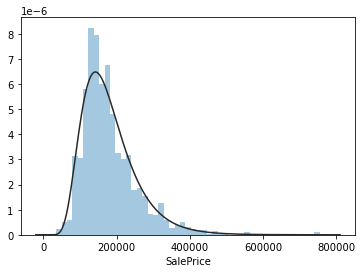

In [3]:
response = 'SalePrice'
sns.distplot(df_raw[response], kde=False, fit=stats.lognorm);


/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


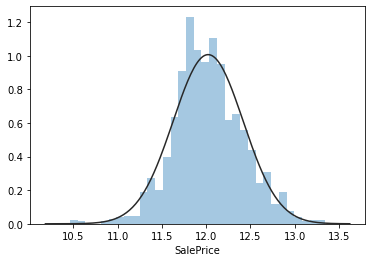

In [4]:
sns.distplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), kde=False, fit=stats.norm);


/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


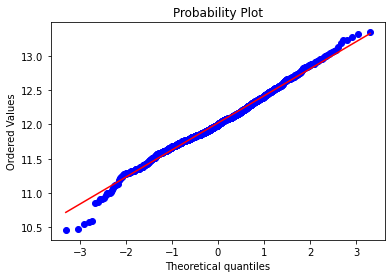

In [5]:
res = stats.probplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), plot=plt);


In [6]:
df_raw.columns

/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
df_raw['target'] = np.log1p(df_raw['SalePrice'])
response = 'target'
df_raw                                              
                                        

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,target
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,12.072547
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,12.254868
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,12.493133
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2010,WD,Normal,142125,11.864469


In [8]:
predictors = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition',
             ]

df_raw[predictors + [response]]

/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,target
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.072547
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.254868
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493133
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864469


In [12]:
df_train, df_test = train_test_split(df_raw, test_size=.25)


/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
train_data = task.Dataset(df_train[predictors + [response]])
test_data = task.Dataset(df_test[predictors + [response]])


In [14]:
predictor_saleprice = task.fit(train_data=train_data, output_directory="agModels-predictSalePrice", label=response, time_limits=600)
performance = predictor_saleprice.evaluate(test_data)

Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to agModels-predictSalePrice/
AutoGluon Version:  0.0.15
Train Data Rows:    1095
Train Data Columns: 79
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (13.534474352733596, 10.460270761075149, 12.02226, 0.40394)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    31998.22 MB
	Train Data (Original)  Memory Usage: 3.04 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Gener

Predictive performance on given dataset: root_mean_squared_error = 0.12306359001981133


In [15]:
df = pd.read_csv('df_train.csv')
df

/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,HalfBath_1,HalfBath_2,PoolQC_0,TotalBath_1.0,TotalBath_1.5,TotalBath_2.0,TotalBath_2.5,TotalBath_3.0,TotalBath_3.5,TotalBath_4.0
0,60,3,1,2,1,0,16,3,4,4,...,1,0,1,0,0,0,0,0,1,0
1,20,3,1,2,1,2,20,2,4,4,...,0,0,1,0,0,0,1,0,0,0
2,60,3,1,2,1,0,16,3,4,4,...,1,0,1,0,0,0,0,0,1,0
3,70,3,1,2,1,1,17,3,4,4,...,0,0,1,0,0,1,0,0,0,0
4,60,3,1,2,1,2,23,3,4,4,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,60,3,1,2,1,0,14,3,4,4,...,1,0,1,0,0,0,1,0,0,0
1452,20,3,1,2,1,0,13,3,4,4,...,0,0,1,0,0,0,0,1,0,0
1453,70,3,1,2,1,0,17,3,4,4,...,0,0,1,0,0,1,0,0,0,0
1454,20,3,1,2,1,0,10,3,4,4,...,0,0,1,0,0,1,0,0,0,0


In [16]:
df_train, df_test = train_test_split(df, test_size=.25)
train_data = task.Dataset(df_train)
test_data = task.Dataset(df_test)
full_train = task.Dataset(df)

/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
predictor_saleprice = task.fit(train_data=train_data, output_directory="agModels-predictSalePrice", label='SalePrice', time_limits=600)
performance = predictor_saleprice.evaluate(test_data)


Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to agModels-predictSalePrice/
AutoGluon Version:  0.0.15
Train Data Rows:    1092
Train Data Columns: 424
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (13.34550852871726, 10.460270761075147, 12.01793, 0.39594)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    31925.66 MB
	Train Data (Original)  Memory Usage: 3.71 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Gener

Predictive performance on given dataset: root_mean_squared_error = 0.1143795032058607


In [18]:
# train on full dataset without split
predictor_saleprice = task.fit(problem_type='regression',
                               train_data=full_train, 
                               output_directory="agModels-predictSalePrice", 
                               label='SalePrice', 
                               presets='best_quality',
#                               verbosity=3,
                               time_limits=28800)


/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Beginning AutoGluon training ... Time limit = 28800s
AutoGluon will save models to agModels-predictSalePrice/
AutoGluon Version:  0.0.15
Train Data Rows:    1456
Train Data Columns: 424
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    31854.89 MB
	Train Data (Original)  Memory Usage: 4.94 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator..

[1000]	train_set's rmse: 0.000986142	valid_set's rmse: 0.133099


	-0.1255	 = Validation root_mean_squared_error score
	7.74s	 = Training runtime
	0.04s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 14343.63s of the 28743.5s of remaining time.
	-0.1213	 = Validation root_mean_squared_error score
	4.55s	 = Training runtime
	0.03s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 14339.01s of the 28738.87s of remaining time.
	-0.1133	 = Validation root_mean_squared_error score
	22.55s	 = Training runtime
	0.07s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 14316.35s of the 28716.21s of remaining time.
	-0.1479	 = Validation root_mean_squared_error score
	69.18s	 = Training runtime
	0.8s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 14246.27s of the 28646.14s of remaining time.


[1000]	train_set's rmse: 0.000414625	valid_set's rmse: 0.127589
[1000]	train_set's rmse: 0.00040391	valid_set's rmse: 0.137281
[2000]	train_set's rmse: 2.50542e-05	valid_set's rmse: 0.137255
[1000]	train_set's rmse: 0.000303835	valid_set's rmse: 0.112863


	-0.1303	 = Validation root_mean_squared_error score
	70.05s	 = Training runtime
	0.1s	 = Validation runtime
Repeating k-fold bagging: 2/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 14174.9s of the 28574.76s of remaining time.
	-0.1286	 = Validation root_mean_squared_error score
	47.41s	 = Training runtime
	2.08s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 14150.01s of the 28549.88s of remaining time.
	-0.1248	 = Validation root_mean_squared_error score
	37.61s	 = Training runtime
	2.08s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 14129.7s of the 28529.56s of remaining time.
	-0.2169	 = Validation root_mean_squared_error score
	0.69s	 = Training runtime
	2.07s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 14128.22s of the 28528.09s of remaining time.
	-0.2137	 = Validation root_mean_

[1000]	train_set's rmse: 0.00120371	valid_set's rmse: 0.129965


	-0.1208	 = Validation root_mean_squared_error score
	14.87s	 = Training runtime
	0.07s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 14119.48s of the 28519.35s of remaining time.
	-0.1172	 = Validation root_mean_squared_error score
	8.78s	 = Training runtime
	0.06s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 14115.18s of the 28515.05s of remaining time.
	-0.1114	 = Validation root_mean_squared_error score
	48.2s	 = Training runtime
	0.15s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 14089.42s of the 28489.29s of remaining time.
	-0.1254	 = Validation root_mean_squared_error score
	138.3s	 = Training runtime
	1.6s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 14019.41s of the 28419.28s of remaining time.


[1000]	train_set's rmse: 0.000470741	valid_set's rmse: 0.130742
[2000]	train_set's rmse: 1.32702e-05	valid_set's rmse: 0.130684
[1000]	train_set's rmse: 0.000478754	valid_set's rmse: 0.144454
[2000]	train_set's rmse: 3.45065e-05	valid_set's rmse: 0.144388
[3000]	train_set's rmse: 1.05344e-06	valid_set's rmse: 0.144384
[4000]	train_set's rmse: 4.77399e-08	valid_set's rmse: 0.144384


	-0.1246	 = Validation root_mean_squared_error score
	152.92s	 = Training runtime
	0.22s	 = Validation runtime
Repeating k-fold bagging: 3/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 13934.85s of the 28334.71s of remaining time.
	-0.1282	 = Validation root_mean_squared_error score
	71.27s	 = Training runtime
	3.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 13909.64s of the 28309.51s of remaining time.
	-0.1241	 = Validation root_mean_squared_error score
	56.51s	 = Training runtime
	3.13s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 13889.32s of the 28289.19s of remaining time.
	-0.2165	 = Validation root_mean_squared_error score
	1.04s	 = Training runtime
	3.11s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 13887.84s of the 28287.71s of remaining time.
	-0.213	 = Validation root_me

[1000]	train_set's rmse: 0.000284279	valid_set's rmse: 0.130583
[1000]	train_set's rmse: 0.000463183	valid_set's rmse: 0.139999
[2000]	train_set's rmse: 3.62264e-05	valid_set's rmse: 0.139908
[1000]	train_set's rmse: 0.000340026	valid_set's rmse: 0.125453
[1000]	train_set's rmse: 0.000409688	valid_set's rmse: 0.130784


	-0.1232	 = Validation root_mean_squared_error score
	232.69s	 = Training runtime
	0.33s	 = Validation runtime
Repeating k-fold bagging: 4/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 13706.39s of the 28106.26s of remaining time.
	-0.1277	 = Validation root_mean_squared_error score
	94.61s	 = Training runtime
	4.16s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 13681.72s of the 28081.59s of remaining time.
	-0.1237	 = Validation root_mean_squared_error score
	74.71s	 = Training runtime
	4.27s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 13662.01s of the 28061.87s of remaining time.
	-0.2154	 = Validation root_mean_squared_error score
	1.39s	 = Training runtime
	4.15s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 13660.52s of the 28060.38s of remaining time.
	-0.2121	 = Validation root_m

[1000]	train_set's rmse: 0.000438555	valid_set's rmse: 0.136942
[2000]	train_set's rmse: 4.50994e-05	valid_set's rmse: 0.13691
[3000]	train_set's rmse: 5.03583e-06	valid_set's rmse: 0.136908
[1000]	train_set's rmse: 0.000487812	valid_set's rmse: 0.148327


	-0.1221	 = Validation root_mean_squared_error score
	287.59s	 = Training runtime
	0.41s	 = Validation runtime
Repeating k-fold bagging: 5/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 13499.38s of the 27899.25s of remaining time.
	-0.1277	 = Validation root_mean_squared_error score
	118.58s	 = Training runtime
	5.2s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 13474.07s of the 27873.94s of remaining time.
	-0.1237	 = Validation root_mean_squared_error score
	93.7s	 = Training runtime
	5.31s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 13453.66s of the 27853.52s of remaining time.
	-0.2156	 = Validation root_mean_squared_error score
	1.74s	 = Training runtime
	5.18s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 13452.17s of the 27852.04s of remaining time.
	-0.2122	 = Validation root_me

[1000]	train_set's rmse: 0.00143872	valid_set's rmse: 0.134886
[2000]	train_set's rmse: 0.000185807	valid_set's rmse: 0.134579


	-0.1188	 = Validation root_mean_squared_error score
	42.91s	 = Training runtime
	0.21s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 13249.28s of the 27649.14s of remaining time.
	-0.1155	 = Validation root_mean_squared_error score
	25.94s	 = Training runtime
	0.19s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 13244.64s of the 27644.5s of remaining time.
	-0.1087	 = Validation root_mean_squared_error score
	150.89s	 = Training runtime
	0.45s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 13223.7s of the 27623.56s of remaining time.
	-0.1113	 = Validation root_mean_squared_error score
	412.04s	 = Training runtime
	4.82s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 13146.19s of the 27546.05s of remaining time.


[1000]	train_set's rmse: 0.000266521	valid_set's rmse: 0.138603
[1000]	train_set's rmse: 0.000586321	valid_set's rmse: 0.139385
[2000]	train_set's rmse: 4.44968e-05	valid_set's rmse: 0.139309
[3000]	train_set's rmse: 4.17036e-06	valid_set's rmse: 0.139305
[4000]	train_set's rmse: 2.2448e-07	valid_set's rmse: 0.139305
[5000]	train_set's rmse: 2.08696e-08	valid_set's rmse: 0.139305
[1000]	train_set's rmse: 0.000224256	valid_set's rmse: 0.110453


	-0.1215	 = Validation root_mean_squared_error score
	405.56s	 = Training runtime
	0.59s	 = Validation runtime
Repeating k-fold bagging: 7/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 13057.75s of the 27457.61s of remaining time.
	-0.1277	 = Validation root_mean_squared_error score
	166.49s	 = Training runtime
	7.28s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 13032.44s of the 27432.3s of remaining time.
	-0.1234	 = Validation root_mean_squared_error score
	131.47s	 = Training runtime
	7.39s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 13012.14s of the 27412.01s of remaining time.
	-0.2154	 = Validation root_mean_squared_error score
	2.42s	 = Training runtime
	7.25s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 13010.66s of the 27410.53s of remaining time.
	-0.212	 = Validation root_m

[1000]	train_set's rmse: 0.000969759	valid_set's rmse: 0.121795


	-0.119	 = Validation root_mean_squared_error score
	50.14s	 = Training runtime
	0.25s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 13001.82s of the 27401.69s of remaining time.
	-0.1156	 = Validation root_mean_squared_error score
	30.16s	 = Training runtime
	0.22s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 12997.53s of the 27397.4s of remaining time.
	-0.1089	 = Validation root_mean_squared_error score
	173.04s	 = Training runtime
	0.52s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 12975.28s of the 27375.15s of remaining time.
	-0.1097	 = Validation root_mean_squared_error score
	497.01s	 = Training runtime
	5.63s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 12889.4s of the 27289.26s of remaining time.


[1000]	train_set's rmse: 0.000394941	valid_set's rmse: 0.123784
[1000]	train_set's rmse: 0.000376298	valid_set's rmse: 0.152197
[1000]	train_set's rmse: 0.000466352	valid_set's rmse: 0.126815
[1000]	train_set's rmse: 0.000335179	valid_set's rmse: 0.126869
[2000]	train_set's rmse: 1.56249e-05	valid_set's rmse: 0.126778
[3000]	train_set's rmse: 1.14651e-06	valid_set's rmse: 0.126772
[4000]	train_set's rmse: 6.5169e-08	valid_set's rmse: 0.126772
[5000]	train_set's rmse: 4.29722e-09	valid_set's rmse: 0.126772
[6000]	train_set's rmse: 5.04655e-10	valid_set's rmse: 0.126772


	-0.1215	 = Validation root_mean_squared_error score
	509.13s	 = Training runtime
	0.75s	 = Validation runtime
Repeating k-fold bagging: 8/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 12783.72s of the 27183.58s of remaining time.
	-0.1277	 = Validation root_mean_squared_error score
	190.44s	 = Training runtime
	8.33s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 12758.39s of the 27158.26s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	150.26s	 = Training runtime
	8.44s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 12738.18s of the 27138.05s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	2.77s	 = Training runtime
	8.29s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 12736.7s of the 27136.57s of remaining time.
	-0.2118	 = Validation root_

[1000]	train_set's rmse: 0.0002226	valid_set's rmse: 0.148555
[2000]	train_set's rmse: 4.18601e-06	valid_set's rmse: 0.148539


	-0.1214	 = Validation root_mean_squared_error score
	558.74s	 = Training runtime
	0.82s	 = Validation runtime
Repeating k-fold bagging: 9/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 12573.88s of the 26973.75s of remaining time.
	-0.1279	 = Validation root_mean_squared_error score
	214.19s	 = Training runtime
	9.37s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 12548.78s of the 26948.64s of remaining time.
	-0.1233	 = Validation root_mean_squared_error score
	169.18s	 = Training runtime
	9.48s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 12528.43s of the 26928.3s of remaining time.
	-0.215	 = Validation root_mean_squared_error score
	3.11s	 = Training runtime
	9.33s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 12526.95s of the 26926.82s of remaining time.
	-0.2115	 = Validation root_m

[1000]	train_set's rmse: 0.000265206	valid_set's rmse: 0.120172
[1000]	train_set's rmse: 0.00032764	valid_set's rmse: 0.144423
[1000]	train_set's rmse: 0.000340313	valid_set's rmse: 0.124062
[1000]	train_set's rmse: 0.00062133	valid_set's rmse: 0.121837
[2000]	train_set's rmse: 3.9981e-05	valid_set's rmse: 0.121743
[3000]	train_set's rmse: 7.23385e-07	valid_set's rmse: 0.121734


	-0.1218	 = Validation root_mean_squared_error score
	642.21s	 = Training runtime
	0.94s	 = Validation runtime
Repeating k-fold bagging: 10/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 12321.08s of the 26720.94s of remaining time.
	-0.1279	 = Validation root_mean_squared_error score
	238.15s	 = Training runtime
	10.41s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 12295.78s of the 26695.64s of remaining time.
	-0.1233	 = Validation root_mean_squared_error score
	187.98s	 = Training runtime
	10.52s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 12275.57s of the 26675.43s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	3.46s	 = Training runtime
	10.36s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 12274.08s of the 26673.95s of remaining time.
	-0.2118	 = Validation 

[1000]	train_set's rmse: 0.00039851	valid_set's rmse: 0.128453
[1000]	train_set's rmse: 0.000416796	valid_set's rmse: 0.132523
[1000]	train_set's rmse: 0.000381984	valid_set's rmse: 0.124187
[2000]	train_set's rmse: 2.51909e-05	valid_set's rmse: 0.124068
[3000]	train_set's rmse: 2.42542e-06	valid_set's rmse: 0.124066


	-0.1216	 = Validation root_mean_squared_error score
	718.59s	 = Training runtime
	1.05s	 = Validation runtime
Repeating k-fold bagging: 11/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 12087.05s of the 26486.92s of remaining time.
	-0.128	 = Validation root_mean_squared_error score
	262.1s	 = Training runtime
	11.46s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 12061.77s of the 26461.63s of remaining time.
	-0.1233	 = Validation root_mean_squared_error score
	206.68s	 = Training runtime
	11.57s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 12041.65s of the 26441.52s of remaining time.
	-0.2151	 = Validation root_mean_squared_error score
	3.8s	 = Training runtime
	11.4s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 12040.19s of the 26440.05s of remaining time.
	-0.2116	 = Validation root

[1000]	train_set's rmse: 0.000536879	valid_set's rmse: 0.128195
[2000]	train_set's rmse: 3.24383e-05	valid_set's rmse: 0.128158
[1000]	train_set's rmse: 0.000597283	valid_set's rmse: 0.145397
[2000]	train_set's rmse: 2.51467e-05	valid_set's rmse: 0.145366
[3000]	train_set's rmse: 1.61215e-06	valid_set's rmse: 0.145363


	-0.1217	 = Validation root_mean_squared_error score
	785.76s	 = Training runtime
	1.17s	 = Validation runtime
Repeating k-fold bagging: 12/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 11868.35s of the 26268.22s of remaining time.
	-0.128	 = Validation root_mean_squared_error score
	286.05s	 = Training runtime
	12.5s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 11843.07s of the 26242.94s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	225.37s	 = Training runtime
	12.61s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 11822.95s of the 26222.82s of remaining time.
	-0.2151	 = Validation root_mean_squared_error score
	4.14s	 = Training runtime
	12.44s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 11821.48s of the 26221.35s of remaining time.
	-0.2116	 = Validation ro

[1000]	train_set's rmse: 0.000657014	valid_set's rmse: 0.129071


	-0.1214	 = Validation root_mean_squared_error score
	824.64s	 = Training runtime
	1.22s	 = Validation runtime
Repeating k-fold bagging: 13/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 11674.22s of the 26074.08s of remaining time.
	-0.128	 = Validation root_mean_squared_error score
	309.79s	 = Training runtime
	13.54s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 11649.14s of the 26049.0s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	244.16s	 = Training runtime
	13.65s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 11628.92s of the 26028.79s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	4.48s	 = Training runtime
	13.47s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 11627.45s of the 26027.32s of remaining time.
	-0.2117	 = Validation ro

[1000]	train_set's rmse: 0.000403124	valid_set's rmse: 0.139404


	-0.1217	 = Validation root_mean_squared_error score
	862.77s	 = Training runtime
	1.26s	 = Validation runtime
Repeating k-fold bagging: 14/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 11476.73s of the 25876.6s of remaining time.
	-0.1281	 = Validation root_mean_squared_error score
	333.55s	 = Training runtime
	14.58s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 11451.62s of the 25851.49s of remaining time.
	-0.1233	 = Validation root_mean_squared_error score
	262.86s	 = Training runtime
	14.79s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 11431.4s of the 25831.27s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	4.82s	 = Training runtime
	14.51s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 11429.91s of the 25829.77s of remaining time.
	-0.2118	 = Validation ro

[1000]	train_set's rmse: 0.0014291	valid_set's rmse: 0.116369
[2000]	train_set's rmse: 0.000194786	valid_set's rmse: 0.116209


	-0.1188	 = Validation root_mean_squared_error score
	95.44s	 = Training runtime
	0.48s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 11417.93s of the 25817.8s of remaining time.
	-0.1152	 = Validation root_mean_squared_error score
	61.13s	 = Training runtime
	0.44s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 11413.68s of the 25813.54s of remaining time.
	-0.1086	 = Validation root_mean_squared_error score
	351.42s	 = Training runtime
	1.05s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 11386.24s of the 25786.11s of remaining time.
	-0.1064	 = Validation root_mean_squared_error score
	1006.2s	 = Training runtime
	11.29s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 11312.56s of the 25712.42s of remaining time.


[1000]	train_set's rmse: 0.000287233	valid_set's rmse: 0.128971
[1000]	train_set's rmse: 0.000380109	valid_set's rmse: 0.11278
[2000]	train_set's rmse: 2.4441e-05	valid_set's rmse: 0.11266
[3000]	train_set's rmse: 3.15128e-06	valid_set's rmse: 0.112658
[4000]	train_set's rmse: 5.82214e-07	valid_set's rmse: 0.112658
[1000]	train_set's rmse: 0.000444781	valid_set's rmse: 0.127975


	-0.1217	 = Validation root_mean_squared_error score
	947.62s	 = Training runtime
	1.39s	 = Validation runtime
Repeating k-fold bagging: 15/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 11226.02s of the 25625.88s of remaining time.
	-0.128	 = Validation root_mean_squared_error score
	357.41s	 = Training runtime
	15.62s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 11200.82s of the 25600.69s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	281.36s	 = Training runtime
	15.94s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 11180.8s of the 25580.66s of remaining time.
	-0.2152	 = Validation root_mean_squared_error score
	5.16s	 = Training runtime
	15.54s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 11179.32s of the 25579.19s of remaining time.
	-0.2117	 = Validation ro

[1000]	train_set's rmse: 0.00103717	valid_set's rmse: 0.13752


	-0.1186	 = Validation root_mean_squared_error score
	102.79s	 = Training runtime
	0.52s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 11170.35s of the 25570.22s of remaining time.
	-0.1152	 = Validation root_mean_squared_error score
	65.49s	 = Training runtime
	0.47s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 11165.92s of the 25565.79s of remaining time.
	-0.1083	 = Validation root_mean_squared_error score
	373.28s	 = Training runtime
	1.13s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 11143.88s of the 25543.75s of remaining time.
	-0.106	 = Validation root_mean_squared_error score
	1083.43s	 = Training runtime
	12.11s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 11065.73s of the 25465.6s of remaining time.


[1000]	train_set's rmse: 0.000641238	valid_set's rmse: 0.145667
[2000]	train_set's rmse: 4.62611e-05	valid_set's rmse: 0.14556
[3000]	train_set's rmse: 2.1277e-06	valid_set's rmse: 0.145556


	-0.1217	 = Validation root_mean_squared_error score
	998.13s	 = Training runtime
	1.47s	 = Validation runtime
Repeating k-fold bagging: 16/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 11014.25s of the 25414.12s of remaining time.
	-0.1279	 = Validation root_mean_squared_error score
	381.25s	 = Training runtime
	16.66s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 10989.06s of the 25388.93s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	300.06s	 = Training runtime
	17.08s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 10968.84s of the 25368.7s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	5.51s	 = Training runtime
	16.58s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 10967.35s of the 25367.22s of remaining time.
	-0.2117	 = Validation r

[1000]	train_set's rmse: 0.000956649	valid_set's rmse: 0.12066


	-0.1185	 = Validation root_mean_squared_error score
	110.21s	 = Training runtime
	0.55s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 10958.32s of the 25358.18s of remaining time.
	-0.1151	 = Validation root_mean_squared_error score
	70.14s	 = Training runtime
	0.5s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 10953.58s of the 25353.45s of remaining time.
	-0.1084	 = Validation root_mean_squared_error score
	396.8s	 = Training runtime
	1.2s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 10929.95s of the 25329.81s of remaining time.
	-0.1059	 = Validation root_mean_squared_error score
	1163.28s	 = Training runtime
	12.92s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 10849.19s of the 25249.05s of remaining time.


[1000]	train_set's rmse: 0.000524792	valid_set's rmse: 0.126367
[2000]	train_set's rmse: 4.74416e-05	valid_set's rmse: 0.126305
[1000]	train_set's rmse: 0.000413046	valid_set's rmse: 0.113836


	-0.1216	 = Validation root_mean_squared_error score
	1062.69s	 = Training runtime
	1.56s	 = Validation runtime
Repeating k-fold bagging: 17/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 10783.4s of the 25183.27s of remaining time.
	-0.1278	 = Validation root_mean_squared_error score
	405.14s	 = Training runtime
	17.71s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 10758.16s of the 25158.03s of remaining time.
	-0.1231	 = Validation root_mean_squared_error score
	318.79s	 = Training runtime
	18.23s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 10737.91s of the 25137.78s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	5.85s	 = Training runtime
	17.62s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 10736.44s of the 25136.31s of remaining time.
	-0.2117	 = Validation 

[1000]	train_set's rmse: 0.000573264	valid_set's rmse: 0.13795
[2000]	train_set's rmse: 4.68419e-05	valid_set's rmse: 0.13782
[3000]	train_set's rmse: 3.90014e-06	valid_set's rmse: 0.137815
[1000]	train_set's rmse: 0.000286002	valid_set's rmse: 0.126607
[1000]	train_set's rmse: 0.000313754	valid_set's rmse: 0.110097
[2000]	train_set's rmse: 2.02258e-05	valid_set's rmse: 0.110039


	-0.1215	 = Validation root_mean_squared_error score
	1144.13s	 = Training runtime
	1.68s	 = Validation runtime
Repeating k-fold bagging: 18/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 10550.16s of the 24950.03s of remaining time.
	-0.1278	 = Validation root_mean_squared_error score
	428.99s	 = Training runtime
	18.75s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 10524.95s of the 24924.82s of remaining time.
	-0.1231	 = Validation root_mean_squared_error score
	337.6s	 = Training runtime
	19.37s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 10504.62s of the 24904.48s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	6.19s	 = Training runtime
	18.65s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 10503.13s of the 24903.0s of remaining time.
	-0.2118	 = Validation r

[1000]	train_set's rmse: 0.00127571	valid_set's rmse: 0.141078
[2000]	train_set's rmse: 0.000137956	valid_set's rmse: 0.140903
[3000]	train_set's rmse: 1.97362e-05	valid_set's rmse: 0.140892
[4000]	train_set's rmse: 3.1111e-06	valid_set's rmse: 0.140891


	-0.1185	 = Validation root_mean_squared_error score
	128.41s	 = Training runtime
	0.64s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 10488.82s of the 24888.69s of remaining time.
	-0.1151	 = Validation root_mean_squared_error score
	79.46s	 = Training runtime
	0.57s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 10483.66s of the 24883.53s of remaining time.
	-0.1083	 = Validation root_mean_squared_error score
	448.89s	 = Training runtime
	1.36s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 10456.94s of the 24856.81s of remaining time.
	-0.1057	 = Validation root_mean_squared_error score
	1284.16s	 = Training runtime
	14.54s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 10400.19s of the 24800.06s of remaining time.


[1000]	train_set's rmse: 0.000361777	valid_set's rmse: 0.131714
[2000]	train_set's rmse: 2.65056e-05	valid_set's rmse: 0.13167
[1000]	train_set's rmse: 0.000364829	valid_set's rmse: 0.120751
[1000]	train_set's rmse: 0.000237359	valid_set's rmse: 0.10868


	-0.1215	 = Validation root_mean_squared_error score
	1208.25s	 = Training runtime
	1.76s	 = Validation runtime
Repeating k-fold bagging: 19/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 10334.99s of the 24734.85s of remaining time.
	-0.1279	 = Validation root_mean_squared_error score
	452.45s	 = Training runtime
	19.79s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 10310.2s of the 24710.07s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	356.4s	 = Training runtime
	20.41s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 10289.99s of the 24689.86s of remaining time.
	-0.2155	 = Validation root_mean_squared_error score
	6.54s	 = Training runtime
	19.69s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 10288.5s of the 24688.36s of remaining time.
	-0.2119	 = Validation ro

[1000]	train_set's rmse: 0.000489672	valid_set's rmse: 0.130984
[1000]	train_set's rmse: 0.000539861	valid_set's rmse: 0.135242


	-0.1216	 = Validation root_mean_squared_error score
	1260.36s	 = Training runtime
	1.83s	 = Validation runtime
Repeating k-fold bagging: 20/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 10123.48s of the 24523.35s of remaining time.
	-0.1279	 = Validation root_mean_squared_error score
	476.4s	 = Training runtime
	20.84s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 10098.19s of the 24498.06s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	375.22s	 = Training runtime
	21.46s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 10077.94s of the 24477.81s of remaining time.
	-0.2154	 = Validation root_mean_squared_error score
	6.88s	 = Training runtime
	20.73s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 10076.45s of the 24476.32s of remaining time.
	-0.2118	 = Validation 

[1000]	train_set's rmse: 0.000382511	valid_set's rmse: 0.114133
[2000]	train_set's rmse: 3.67502e-05	valid_set's rmse: 0.114071
[1000]	train_set's rmse: 0.00043836	valid_set's rmse: 0.134876


	-0.1215	 = Validation root_mean_squared_error score
	1315.43s	 = Training runtime
	1.91s	 = Validation runtime
Completed 20/20 k-fold bagging repeats ...
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 1439.99s of the 24312.98s of remaining time.
	-0.1038	 = Validation root_mean_squared_error score
	0.33s	 = Training runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 24312.64s of the 24312.64s of remaining time.
	-0.1116	 = Validation root_mean_squared_error score
	26.76s	 = Training runtime
	1.04s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 24284.55s of the 24284.54s of remaining time.
	-0.1141	 = Validation root_mean_squared_error score
	21.1s	 = Training runtime
	1.04s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 24262.04s of the 24262.04s of remaining time.
	-0.2176	 = Validation root_me

[1000]	train_set's rmse: 0.000213955	valid_set's rmse: 0.123741
[2000]	train_set's rmse: 2.48669e-06	valid_set's rmse: 0.123712
[3000]	train_set's rmse: 3.09651e-08	valid_set's rmse: 0.123712
[4000]	train_set's rmse: 3.91699e-10	valid_set's rmse: 0.123712
[5000]	train_set's rmse: 6.19744e-12	valid_set's rmse: 0.123712


	-0.1131	 = Validation root_mean_squared_error score
	107.11s	 = Training runtime
	0.16s	 = Validation runtime
Repeating k-fold bagging: 3/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 23902.06s of the 23902.05s of remaining time.
	-0.1104	 = Validation root_mean_squared_error score
	80.07s	 = Training runtime
	3.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 23874.17s of the 23874.16s of remaining time.
	-0.1127	 = Validation root_mean_squared_error score
	63.52s	 = Training runtime
	3.23s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 23851.64s of the 23851.64s of remaining time.
	-0.2149	 = Validation root_mean_squared_error score
	1.13s	 = Training runtime
	3.11s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 23850.12s of the 23850.12s of remaining time.
	-0.2114	 = Validation root_m

[1000]	train_set's rmse: 0.000272552	valid_set's rmse: 0.110048


	-0.1121	 = Validation root_mean_squared_error score
	147.99s	 = Training runtime
	0.21s	 = Validation runtime
Repeating k-fold bagging: 4/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 23710.54s of the 23710.54s of remaining time.
	-0.11	 = Validation root_mean_squared_error score
	106.02s	 = Training runtime
	4.16s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 23683.25s of the 23683.25s of remaining time.
	-0.1126	 = Validation root_mean_squared_error score
	83.9s	 = Training runtime
	4.28s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 23661.46s of the 23661.45s of remaining time.
	-0.2149	 = Validation root_mean_squared_error score
	1.51s	 = Training runtime
	4.14s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 23659.94s of the 23659.94s of remaining time.
	-0.2113	 = Validation root_mea

[1000]	train_set's rmse: 0.000356754	valid_set's rmse: 0.10834


	-0.1112	 = Validation root_mean_squared_error score
	214.82s	 = Training runtime
	0.3s	 = Validation runtime
Repeating k-fold bagging: 6/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 23348.96s of the 23348.96s of remaining time.
	-0.1098	 = Validation root_mean_squared_error score
	159.62s	 = Training runtime
	6.25s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 23320.67s of the 23320.67s of remaining time.
	-0.1121	 = Validation root_mean_squared_error score
	126.04s	 = Training runtime
	6.46s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 23298.12s of the 23298.11s of remaining time.
	-0.2141	 = Validation root_mean_squared_error score
	2.26s	 = Training runtime
	6.22s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 23296.6s of the 23296.6s of remaining time.
	-0.2108	 = Validation root_me

[1000]	train_set's rmse: 0.000194782	valid_set's rmse: 0.123905
[2000]	train_set's rmse: 2.35924e-06	valid_set's rmse: 0.123866


	-0.1112	 = Validation root_mean_squared_error score
	285.71s	 = Training runtime
	0.39s	 = Validation runtime
Repeating k-fold bagging: 8/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 22971.4s of the 22971.39s of remaining time.
	-0.1098	 = Validation root_mean_squared_error score
	213.31s	 = Training runtime
	8.33s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 22943.12s of the 22943.11s of remaining time.
	-0.1122	 = Validation root_mean_squared_error score
	168.37s	 = Training runtime
	8.65s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 22920.56s of the 22920.56s of remaining time.
	-0.2146	 = Validation root_mean_squared_error score
	3.01s	 = Training runtime
	8.29s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 22919.04s of the 22919.04s of remaining time.
	-0.2111	 = Validation root_

[1000]	train_set's rmse: 0.000278313	valid_set's rmse: 0.124832
[2000]	train_set's rmse: 1.19738e-05	valid_set's rmse: 0.124789
[3000]	train_set's rmse: 2.85291e-07	valid_set's rmse: 0.124788
[4000]	train_set's rmse: 1.81922e-08	valid_set's rmse: 0.124788


	-0.1112	 = Validation root_mean_squared_error score
	356.77s	 = Training runtime
	0.48s	 = Validation runtime
Repeating k-fold bagging: 9/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 22749.94s of the 22749.94s of remaining time.
	-0.1096	 = Validation root_mean_squared_error score
	240.27s	 = Training runtime
	9.37s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 22721.64s of the 22721.63s of remaining time.
	-0.1121	 = Validation root_mean_squared_error score
	189.48s	 = Training runtime
	9.8s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 22699.01s of the 22699.0s of remaining time.
	-0.2144	 = Validation root_mean_squared_error score
	3.38s	 = Training runtime
	9.32s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 22697.5s of the 22697.5s of remaining time.
	-0.2109	 = Validation root_mea

[1000]	train_set's rmse: 0.000377386	valid_set's rmse: 0.122499
[2000]	train_set's rmse: 2.6126e-05	valid_set's rmse: 0.122444
[3000]	train_set's rmse: 2.40528e-06	valid_set's rmse: 0.12244


	-0.111	 = Validation root_mean_squared_error score
	408.53s	 = Training runtime
	0.55s	 = Validation runtime
Repeating k-fold bagging: 10/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 22554.96s of the 22554.95s of remaining time.
	-0.1097	 = Validation root_mean_squared_error score
	267.32s	 = Training runtime
	10.41s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 22526.57s of the 22526.57s of remaining time.
	-0.1123	 = Validation root_mean_squared_error score
	210.38s	 = Training runtime
	10.94s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 22504.15s of the 22504.14s of remaining time.
	-0.2145	 = Validation root_mean_squared_error score
	3.75s	 = Training runtime
	10.36s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 22502.63s of the 22502.63s of remaining time.
	-0.211	 = Validation ro

[1000]	train_set's rmse: 0.000358212	valid_set's rmse: 0.121376


	-0.1111	 = Validation root_mean_squared_error score
	450.21s	 = Training runtime
	0.6s	 = Validation runtime
Repeating k-fold bagging: 11/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 22379.22s of the 22379.22s of remaining time.
	-0.1097	 = Validation root_mean_squared_error score
	294.29s	 = Training runtime
	11.45s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 22350.92s of the 22350.91s of remaining time.
	-0.1122	 = Validation root_mean_squared_error score
	231.59s	 = Training runtime
	12.08s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 22328.18s of the 22328.18s of remaining time.
	-0.2148	 = Validation root_mean_squared_error score
	4.13s	 = Training runtime
	11.39s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 22326.66s of the 22326.66s of remaining time.
	-0.2112	 = Validation r

[1000]	train_set's rmse: 0.000231292	valid_set's rmse: 0.129734


	-0.111	 = Validation root_mean_squared_error score
	483.83s	 = Training runtime
	0.64s	 = Validation runtime
Repeating k-fold bagging: 12/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 22207.45s of the 22207.45s of remaining time.
	-0.1097	 = Validation root_mean_squared_error score
	321.16s	 = Training runtime
	12.5s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 22179.25s of the 22179.25s of remaining time.
	-0.1124	 = Validation root_mean_squared_error score
	252.8s	 = Training runtime
	13.23s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 22156.52s of the 22156.52s of remaining time.
	-0.2149	 = Validation root_mean_squared_error score
	4.51s	 = Training runtime
	12.43s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 22155.0s of the 22155.0s of remaining time.
	-0.2114	 = Validation root_

[1000]	train_set's rmse: 0.000248344	valid_set's rmse: 0.115795
[2000]	train_set's rmse: 2.54466e-06	valid_set's rmse: 0.115772
[3000]	train_set's rmse: 3.413e-08	valid_set's rmse: 0.115771
[4000]	train_set's rmse: 5.7093e-10	valid_set's rmse: 0.115771


	-0.1111	 = Validation root_mean_squared_error score
	544.56s	 = Training runtime
	0.73s	 = Validation runtime
Repeating k-fold bagging: 13/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 22000.36s of the 22000.36s of remaining time.
	-0.1097	 = Validation root_mean_squared_error score
	347.81s	 = Training runtime
	13.54s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 21972.37s of the 21972.36s of remaining time.
	-0.1122	 = Validation root_mean_squared_error score
	273.91s	 = Training runtime
	14.37s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 21949.72s of the 21949.72s of remaining time.
	-0.2149	 = Validation root_mean_squared_error score
	4.89s	 = Training runtime
	13.47s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 21948.2s of the 21948.2s of remaining time.
	-0.2113	 = Validation ro

[1000]	train_set's rmse: 0.000354462	valid_set's rmse: 0.118774


	-0.1111	 = Validation root_mean_squared_error score
	585.86s	 = Training runtime
	0.78s	 = Validation runtime
Repeating k-fold bagging: 14/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 21799.18s of the 21799.18s of remaining time.
	-0.1097	 = Validation root_mean_squared_error score
	374.69s	 = Training runtime
	14.58s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 21770.96s of the 21770.95s of remaining time.
	-0.1123	 = Validation root_mean_squared_error score
	295.01s	 = Training runtime
	15.51s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 21748.33s of the 21748.32s of remaining time.
	-0.215	 = Validation root_mean_squared_error score
	5.26s	 = Training runtime
	14.5s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 21746.8s of the 21746.8s of remaining time.
	-0.2114	 = Validation root

[1000]	train_set's rmse: 0.000285018	valid_set's rmse: 0.115081
[1000]	train_set's rmse: 0.000250823	valid_set's rmse: 0.115424


	-0.1109	 = Validation root_mean_squared_error score
	658.42s	 = Training runtime
	0.87s	 = Validation runtime
Repeating k-fold bagging: 16/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 21423.55s of the 21423.54s of remaining time.
	-0.1096	 = Validation root_mean_squared_error score
	428.39s	 = Training runtime
	16.67s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 21395.35s of the 21395.35s of remaining time.
	-0.1123	 = Validation root_mean_squared_error score
	337.31s	 = Training runtime
	17.71s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 21372.72s of the 21372.72s of remaining time.
	-0.215	 = Validation root_mean_squared_error score
	6.02s	 = Training runtime
	16.57s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 21371.2s of the 21371.19s of remaining time.
	-0.2114	 = Validation ro

[1000]	train_set's rmse: 0.000283097	valid_set's rmse: 0.123725


	-0.1109	 = Validation root_mean_squared_error score
	694.76s	 = Training runtime
	0.91s	 = Validation runtime
Repeating k-fold bagging: 17/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 21239.22s of the 21239.22s of remaining time.
	-0.1096	 = Validation root_mean_squared_error score
	455.25s	 = Training runtime
	17.71s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 21211.03s of the 21211.02s of remaining time.
	-0.1123	 = Validation root_mean_squared_error score
	358.52s	 = Training runtime
	18.85s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 21188.29s of the 21188.28s of remaining time.
	-0.2149	 = Validation root_mean_squared_error score
	6.4s	 = Training runtime
	17.61s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 21186.77s of the 21186.76s of remaining time.
	-0.2113	 = Validation r

	-0.106	 = Validation root_mean_squared_error score
	1365.29s	 = Training runtime
	16.17s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l1 ... Training model for up to 20575.31s of the 20575.31s of remaining time.


[1000]	train_set's rmse: 0.000371154	valid_set's rmse: 0.124816
[1000]	train_set's rmse: 0.000396117	valid_set's rmse: 0.123559
[2000]	train_set's rmse: 7.848e-06	valid_set's rmse: 0.123551


	-0.1108	 = Validation root_mean_squared_error score
	831.89s	 = Training runtime
	1.09s	 = Validation runtime
Completed 20/20 k-fold bagging repeats ...
Fitting model: weighted_ensemble_k0_l2 ... Training model for up to 2431.26s of the 20517.81s of remaining time.
	-0.1039	 = Validation root_mean_squared_error score
	0.33s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 8282.53s ...


In [19]:
# predict on test data
df_test = pd.read_csv('df_test.csv')
full_test = task.Dataset(df_test)
y_pred = predictor_saleprice.predict(full_test)
y_pred

/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([11.722927, 11.98683 , 12.135532, ..., 12.006582, 11.671776,
       12.289945], dtype=float32)

In [21]:
submit_df = pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': np.expm1(y_pred)})
submit_df.to_csv('autogluon.csv', index=False)
submit_df

/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Id,SalePrice
0,1461,123367.007812
1,1462,160624.328125
2,1463,186377.046875
3,1464,197540.812500
4,1465,184691.171875
...,...,...
1454,2915,89735.468750
1455,2916,82541.750000
1456,2917,163828.625000
1457,2918,117215.250000


In [24]:
# raw data, don't drop outliers
train_data = task.Dataset(df_raw[predictors + [response]])
predictor_saleprice = task.fit(problem_type='regression',
                               train_data=full_train, 
                               output_directory="agModels-predictSalePrice", 
                               label='SalePrice', 
                               presets='best_quality',
#                               verbosity=3,
                               time_limits=28800)

/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Beginning AutoGluon training ... Time limit = 28800s
AutoGluon will save models to agModels-predictSalePrice/
AutoGluon Version:  0.0.15
Train Data Rows:    1456
Train Data Columns: 424
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    30234.15 MB
	Train Data (Original)  Memory Usage: 4.94 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator..

[1000]	train_set's rmse: 0.000986142	valid_set's rmse: 0.133099


	-0.1255	 = Validation root_mean_squared_error score
	7.8s	 = Training runtime
	0.04s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 14343.95s of the 28743.81s of remaining time.
	-0.1213	 = Validation root_mean_squared_error score
	4.57s	 = Training runtime
	0.03s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 14339.31s of the 28739.17s of remaining time.
	-0.1133	 = Validation root_mean_squared_error score
	22.59s	 = Training runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 14316.61s of the 28716.47s of remaining time.
	-0.1411	 = Validation root_mean_squared_error score
	71.86s	 = Training runtime
	0.82s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 14243.85s of the 28643.71s of remaining time.


[1000]	train_set's rmse: 0.000414625	valid_set's rmse: 0.127589
[1000]	train_set's rmse: 0.00040391	valid_set's rmse: 0.137281
[2000]	train_set's rmse: 2.50542e-05	valid_set's rmse: 0.137255
[1000]	train_set's rmse: 0.000303835	valid_set's rmse: 0.112863


	-0.1303	 = Validation root_mean_squared_error score
	70.16s	 = Training runtime
	0.09s	 = Validation runtime
Repeating k-fold bagging: 2/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 14172.37s of the 28572.23s of remaining time.
	-0.1286	 = Validation root_mean_squared_error score
	47.3s	 = Training runtime
	2.08s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 14147.4s of the 28547.25s of remaining time.
	-0.1248	 = Validation root_mean_squared_error score
	37.31s	 = Training runtime
	2.09s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 14127.27s of the 28527.13s of remaining time.
	-0.2169	 = Validation root_mean_squared_error score
	0.68s	 = Training runtime
	2.07s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 14125.8s of the 28525.66s of remaining time.
	-0.2137	 = Validation root_mean_

[1000]	train_set's rmse: 0.00120371	valid_set's rmse: 0.129965


	-0.1208	 = Validation root_mean_squared_error score
	14.91s	 = Training runtime
	0.07s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 14117.08s of the 28516.94s of remaining time.
	-0.1172	 = Validation root_mean_squared_error score
	8.67s	 = Training runtime
	0.06s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 14112.91s of the 28512.77s of remaining time.
	-0.1114	 = Validation root_mean_squared_error score
	48.4s	 = Training runtime
	0.15s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 14086.99s of the 28486.84s of remaining time.
	-0.1268	 = Validation root_mean_squared_error score
	137.85s	 = Training runtime
	1.61s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 14020.1s of the 28419.96s of remaining time.


[1000]	train_set's rmse: 0.000470741	valid_set's rmse: 0.130742
[2000]	train_set's rmse: 1.32702e-05	valid_set's rmse: 0.130684
[1000]	train_set's rmse: 0.000478754	valid_set's rmse: 0.144454
[2000]	train_set's rmse: 3.45065e-05	valid_set's rmse: 0.144388
[3000]	train_set's rmse: 1.05344e-06	valid_set's rmse: 0.144384
[4000]	train_set's rmse: 4.77399e-08	valid_set's rmse: 0.144384


	-0.1246	 = Validation root_mean_squared_error score
	153.74s	 = Training runtime
	0.22s	 = Validation runtime
Repeating k-fold bagging: 3/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 13934.79s of the 28334.65s of remaining time.
	-0.1282	 = Validation root_mean_squared_error score
	70.85s	 = Training runtime
	3.12s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 13909.91s of the 28309.76s of remaining time.
	-0.1241	 = Validation root_mean_squared_error score
	55.72s	 = Training runtime
	3.23s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 13889.98s of the 28289.84s of remaining time.
	-0.2165	 = Validation root_mean_squared_error score
	1.02s	 = Training runtime
	3.11s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 13888.52s of the 28288.38s of remaining time.
	-0.213	 = Validation root_me

[1000]	train_set's rmse: 0.000284279	valid_set's rmse: 0.130583
[1000]	train_set's rmse: 0.000463183	valid_set's rmse: 0.139999
[2000]	train_set's rmse: 3.62264e-05	valid_set's rmse: 0.139908
[1000]	train_set's rmse: 0.000340026	valid_set's rmse: 0.125453
[1000]	train_set's rmse: 0.000409688	valid_set's rmse: 0.130784


	-0.1232	 = Validation root_mean_squared_error score
	233.61s	 = Training runtime
	0.33s	 = Validation runtime
Repeating k-fold bagging: 4/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 13700.02s of the 28099.88s of remaining time.
	-0.1277	 = Validation root_mean_squared_error score
	94.2s	 = Training runtime
	4.16s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 13675.34s of the 28075.19s of remaining time.
	-0.1237	 = Validation root_mean_squared_error score
	74.1s	 = Training runtime
	4.27s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 13655.52s of the 28055.38s of remaining time.
	-0.2154	 = Validation root_mean_squared_error score
	1.36s	 = Training runtime
	4.15s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 13654.05s of the 28053.91s of remaining time.
	-0.2121	 = Validation root_mea

[1000]	train_set's rmse: 0.000438555	valid_set's rmse: 0.136942
[2000]	train_set's rmse: 4.50994e-05	valid_set's rmse: 0.13691
[3000]	train_set's rmse: 5.03583e-06	valid_set's rmse: 0.136908
[1000]	train_set's rmse: 0.000487812	valid_set's rmse: 0.148327


	-0.1221	 = Validation root_mean_squared_error score
	288.06s	 = Training runtime
	0.41s	 = Validation runtime
Repeating k-fold bagging: 5/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 13474.98s of the 27874.84s of remaining time.
	-0.1277	 = Validation root_mean_squared_error score
	117.75s	 = Training runtime
	5.2s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 13450.11s of the 27849.96s of remaining time.
	-0.1237	 = Validation root_mean_squared_error score
	92.78s	 = Training runtime
	5.31s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 13430.01s of the 27829.86s of remaining time.
	-0.2156	 = Validation root_mean_squared_error score
	1.7s	 = Training runtime
	5.18s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 13428.53s of the 27828.39s of remaining time.
	-0.2122	 = Validation root_me

[1000]	train_set's rmse: 0.00143872	valid_set's rmse: 0.134886
[2000]	train_set's rmse: 0.000185807	valid_set's rmse: 0.134579


	-0.1188	 = Validation root_mean_squared_error score
	43.02s	 = Training runtime
	0.21s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 13231.72s of the 27631.58s of remaining time.
	-0.1155	 = Validation root_mean_squared_error score
	25.81s	 = Training runtime
	0.19s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 13227.15s of the 27627.01s of remaining time.
	-0.1087	 = Validation root_mean_squared_error score
	151.12s	 = Training runtime
	0.45s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 13206.13s of the 27605.98s of remaining time.
	-0.1117	 = Validation root_mean_squared_error score
	420.1s	 = Training runtime
	4.95s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 13139.84s of the 27539.69s of remaining time.


[1000]	train_set's rmse: 0.000266521	valid_set's rmse: 0.138603
[1000]	train_set's rmse: 0.000586321	valid_set's rmse: 0.139385
[2000]	train_set's rmse: 4.44968e-05	valid_set's rmse: 0.139309
[3000]	train_set's rmse: 4.17036e-06	valid_set's rmse: 0.139305
[4000]	train_set's rmse: 2.2448e-07	valid_set's rmse: 0.139305
[5000]	train_set's rmse: 2.08696e-08	valid_set's rmse: 0.139305
[1000]	train_set's rmse: 0.000224256	valid_set's rmse: 0.110453


	-0.1215	 = Validation root_mean_squared_error score
	406.47s	 = Training runtime
	0.59s	 = Validation runtime
Repeating k-fold bagging: 7/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 13051.04s of the 27450.9s of remaining time.
	-0.1277	 = Validation root_mean_squared_error score
	165.15s	 = Training runtime
	7.28s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 13025.75s of the 27425.61s of remaining time.
	-0.1234	 = Validation root_mean_squared_error score
	130.04s	 = Training runtime
	7.39s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 13005.76s of the 27405.62s of remaining time.
	-0.2154	 = Validation root_mean_squared_error score
	2.39s	 = Training runtime
	7.26s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 13004.28s of the 27404.14s of remaining time.
	-0.212	 = Validation root_m

[1000]	train_set's rmse: 0.000969759	valid_set's rmse: 0.121795


	-0.119	 = Validation root_mean_squared_error score
	50.09s	 = Training runtime
	0.25s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 12995.61s of the 27395.46s of remaining time.
	-0.1156	 = Validation root_mean_squared_error score
	29.99s	 = Training runtime
	0.22s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 12991.35s of the 27391.21s of remaining time.
	-0.1089	 = Validation root_mean_squared_error score
	173.23s	 = Training runtime
	0.53s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 12969.12s of the 27368.98s of remaining time.
	-0.111	 = Validation root_mean_squared_error score
	471.36s	 = Training runtime
	5.75s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 12916.97s of the 27316.83s of remaining time.


[1000]	train_set's rmse: 0.000394941	valid_set's rmse: 0.123784
[1000]	train_set's rmse: 0.000376298	valid_set's rmse: 0.152197
[1000]	train_set's rmse: 0.000466352	valid_set's rmse: 0.126815
[1000]	train_set's rmse: 0.000335179	valid_set's rmse: 0.126869
[2000]	train_set's rmse: 1.56249e-05	valid_set's rmse: 0.126778
[3000]	train_set's rmse: 1.14651e-06	valid_set's rmse: 0.126772
[4000]	train_set's rmse: 6.5169e-08	valid_set's rmse: 0.126772
[5000]	train_set's rmse: 4.29722e-09	valid_set's rmse: 0.126772
[6000]	train_set's rmse: 5.04655e-10	valid_set's rmse: 0.126772


	-0.1215	 = Validation root_mean_squared_error score
	510.48s	 = Training runtime
	0.75s	 = Validation runtime
Repeating k-fold bagging: 8/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 12810.82s of the 27210.68s of remaining time.
	-0.1277	 = Validation root_mean_squared_error score
	188.99s	 = Training runtime
	8.33s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 12785.56s of the 27185.41s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	149.13s	 = Training runtime
	8.43s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 12765.05s of the 27164.91s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	2.73s	 = Training runtime
	8.29s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 12763.58s of the 27163.44s of remaining time.
	-0.2118	 = Validation root

[1000]	train_set's rmse: 0.0002226	valid_set's rmse: 0.148555
[2000]	train_set's rmse: 4.18601e-06	valid_set's rmse: 0.148539


	-0.1214	 = Validation root_mean_squared_error score
	561.61s	 = Training runtime
	0.82s	 = Validation runtime
Repeating k-fold bagging: 9/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 12609.72s of the 27009.57s of remaining time.
	-0.1279	 = Validation root_mean_squared_error score
	212.74s	 = Training runtime
	9.37s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 12584.63s of the 26984.49s of remaining time.
	-0.1233	 = Validation root_mean_squared_error score
	167.91s	 = Training runtime
	9.47s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 12564.43s of the 26964.29s of remaining time.
	-0.215	 = Validation root_mean_squared_error score
	3.08s	 = Training runtime
	9.33s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 12562.95s of the 26962.8s of remaining time.
	-0.2115	 = Validation root_m

[1000]	train_set's rmse: 0.000265206	valid_set's rmse: 0.120172
[1000]	train_set's rmse: 0.00032764	valid_set's rmse: 0.144423
[1000]	train_set's rmse: 0.000340313	valid_set's rmse: 0.124062
[1000]	train_set's rmse: 0.00062133	valid_set's rmse: 0.121837
[2000]	train_set's rmse: 3.9981e-05	valid_set's rmse: 0.121743
[3000]	train_set's rmse: 7.23385e-07	valid_set's rmse: 0.121734


	-0.1218	 = Validation root_mean_squared_error score
	644.97s	 = Training runtime
	0.94s	 = Validation runtime
Repeating k-fold bagging: 10/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 12358.13s of the 26757.98s of remaining time.
	-0.1279	 = Validation root_mean_squared_error score
	236.39s	 = Training runtime
	10.41s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 12333.13s of the 26732.99s of remaining time.
	-0.1233	 = Validation root_mean_squared_error score
	186.89s	 = Training runtime
	10.52s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 12312.74s of the 26712.6s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	3.42s	 = Training runtime
	10.36s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 12311.26s of the 26711.12s of remaining time.
	-0.2118	 = Validation r

[1000]	train_set's rmse: 0.00039851	valid_set's rmse: 0.128453
[1000]	train_set's rmse: 0.000416796	valid_set's rmse: 0.132523
[1000]	train_set's rmse: 0.000381984	valid_set's rmse: 0.124187
[2000]	train_set's rmse: 2.51909e-05	valid_set's rmse: 0.124068
[3000]	train_set's rmse: 2.42542e-06	valid_set's rmse: 0.124066


	-0.1216	 = Validation root_mean_squared_error score
	721.25s	 = Training runtime
	1.06s	 = Validation runtime
Repeating k-fold bagging: 11/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 12134.15s of the 26534.01s of remaining time.
	-0.128	 = Validation root_mean_squared_error score
	260.24s	 = Training runtime
	11.46s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 12108.96s of the 26508.82s of remaining time.
	-0.1233	 = Validation root_mean_squared_error score
	205.8s	 = Training runtime
	11.56s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 12088.63s of the 26488.49s of remaining time.
	-0.2151	 = Validation root_mean_squared_error score
	3.77s	 = Training runtime
	11.4s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 12087.15s of the 26487.01s of remaining time.
	-0.2116	 = Validation roo

[1000]	train_set's rmse: 0.000536879	valid_set's rmse: 0.128195
[2000]	train_set's rmse: 3.24383e-05	valid_set's rmse: 0.128158
[1000]	train_set's rmse: 0.000597283	valid_set's rmse: 0.145397
[2000]	train_set's rmse: 2.51467e-05	valid_set's rmse: 0.145366
[3000]	train_set's rmse: 1.61215e-06	valid_set's rmse: 0.145363


	-0.1217	 = Validation root_mean_squared_error score
	788.42s	 = Training runtime
	1.17s	 = Validation runtime
Repeating k-fold bagging: 12/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 11909.97s of the 26309.83s of remaining time.
	-0.128	 = Validation root_mean_squared_error score
	284.09s	 = Training runtime
	12.5s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 11884.77s of the 26284.63s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	224.6s	 = Training runtime
	12.6s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 11864.56s of the 26264.42s of remaining time.
	-0.2151	 = Validation root_mean_squared_error score
	4.11s	 = Training runtime
	12.44s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 11863.08s of the 26262.94s of remaining time.
	-0.2116	 = Validation root

[1000]	train_set's rmse: 0.000657014	valid_set's rmse: 0.129071


	-0.1214	 = Validation root_mean_squared_error score
	828.48s	 = Training runtime
	1.21s	 = Validation runtime
Repeating k-fold bagging: 13/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 11717.26s of the 26117.12s of remaining time.
	-0.128	 = Validation root_mean_squared_error score
	307.73s	 = Training runtime
	13.54s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 11692.28s of the 26092.14s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	243.51s	 = Training runtime
	13.64s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 11671.95s of the 26071.81s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	4.45s	 = Training runtime
	13.47s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 11670.47s of the 26070.32s of remaining time.
	-0.2117	 = Validation r

[1000]	train_set's rmse: 0.000403124	valid_set's rmse: 0.139404


	-0.1217	 = Validation root_mean_squared_error score
	866.62s	 = Training runtime
	1.26s	 = Validation runtime
Repeating k-fold bagging: 14/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 11531.8s of the 25931.66s of remaining time.
	-0.1281	 = Validation root_mean_squared_error score
	331.37s	 = Training runtime
	14.58s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 11506.82s of the 25906.68s of remaining time.
	-0.1233	 = Validation root_mean_squared_error score
	262.51s	 = Training runtime
	14.68s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 11486.4s of the 25886.26s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	4.8s	 = Training runtime
	14.51s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 11484.91s of the 25884.77s of remaining time.
	-0.2118	 = Validation roo

[1000]	train_set's rmse: 0.0014291	valid_set's rmse: 0.116369
[2000]	train_set's rmse: 0.000194786	valid_set's rmse: 0.116209


	-0.1188	 = Validation root_mean_squared_error score
	95.94s	 = Training runtime
	0.48s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 11473.09s of the 25872.95s of remaining time.
	-0.1152	 = Validation root_mean_squared_error score
	61.47s	 = Training runtime
	0.44s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 11468.84s of the 25868.7s of remaining time.
	-0.1086	 = Validation root_mean_squared_error score
	351.74s	 = Training runtime
	1.06s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 11441.36s of the 25841.22s of remaining time.
	-0.1073	 = Validation root_mean_squared_error score
	948.3s	 = Training runtime
	11.41s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 11367.86s of the 25767.72s of remaining time.


[1000]	train_set's rmse: 0.000287233	valid_set's rmse: 0.128971
[1000]	train_set's rmse: 0.000380109	valid_set's rmse: 0.11278
[2000]	train_set's rmse: 2.4441e-05	valid_set's rmse: 0.11266
[3000]	train_set's rmse: 3.15128e-06	valid_set's rmse: 0.112658
[4000]	train_set's rmse: 5.82214e-07	valid_set's rmse: 0.112658
[1000]	train_set's rmse: 0.000444781	valid_set's rmse: 0.127975


	-0.1217	 = Validation root_mean_squared_error score
	951.67s	 = Training runtime
	1.39s	 = Validation runtime
Repeating k-fold bagging: 15/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 11281.11s of the 25680.97s of remaining time.
	-0.128	 = Validation root_mean_squared_error score
	355.22s	 = Training runtime
	15.62s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 11255.91s of the 25655.77s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	281.42s	 = Training runtime
	15.83s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 11235.49s of the 25635.35s of remaining time.
	-0.2152	 = Validation root_mean_squared_error score
	5.14s	 = Training runtime
	15.55s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 11234.01s of the 25633.87s of remaining time.
	-0.2117	 = Validation r

[1000]	train_set's rmse: 0.00103717	valid_set's rmse: 0.13752


	-0.1186	 = Validation root_mean_squared_error score
	103.23s	 = Training runtime
	0.52s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 11225.11s of the 25624.96s of remaining time.
	-0.1152	 = Validation root_mean_squared_error score
	65.8s	 = Training runtime
	0.48s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 11220.7s of the 25620.56s of remaining time.
	-0.1083	 = Validation root_mean_squared_error score
	373.63s	 = Training runtime
	1.14s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 11198.69s of the 25598.55s of remaining time.
	-0.1074	 = Validation root_mean_squared_error score
	1016.3s	 = Training runtime
	12.21s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 11129.79s of the 25529.65s of remaining time.


[1000]	train_set's rmse: 0.000641238	valid_set's rmse: 0.145667
[2000]	train_set's rmse: 4.62611e-05	valid_set's rmse: 0.14556
[3000]	train_set's rmse: 2.1277e-06	valid_set's rmse: 0.145556


	-0.1217	 = Validation root_mean_squared_error score
	1003.6s	 = Training runtime
	1.47s	 = Validation runtime
Repeating k-fold bagging: 16/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 11076.88s of the 25476.74s of remaining time.
	-0.1279	 = Validation root_mean_squared_error score
	378.96s	 = Training runtime
	16.66s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 11051.79s of the 25451.64s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	300.23s	 = Training runtime
	16.98s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 11031.46s of the 25431.31s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	5.49s	 = Training runtime
	16.58s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 11029.97s of the 25429.83s of remaining time.
	-0.2117	 = Validation 

[1000]	train_set's rmse: 0.000956649	valid_set's rmse: 0.12066


	-0.1185	 = Validation root_mean_squared_error score
	110.78s	 = Training runtime
	0.55s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 11020.8s of the 25420.65s of remaining time.
	-0.1151	 = Validation root_mean_squared_error score
	70.39s	 = Training runtime
	0.51s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 11016.13s of the 25415.99s of remaining time.
	-0.1084	 = Validation root_mean_squared_error score
	397.23s	 = Training runtime
	1.21s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 10992.42s of the 25392.28s of remaining time.
	-0.1071	 = Validation root_mean_squared_error score
	1092.18s	 = Training runtime
	13.02s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 10915.63s of the 25315.49s of remaining time.


[1000]	train_set's rmse: 0.000524792	valid_set's rmse: 0.126367
[2000]	train_set's rmse: 4.74416e-05	valid_set's rmse: 0.126305
[1000]	train_set's rmse: 0.000413046	valid_set's rmse: 0.113836


	-0.1216	 = Validation root_mean_squared_error score
	1068.18s	 = Training runtime
	1.55s	 = Validation runtime
Repeating k-fold bagging: 17/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 10849.83s of the 25249.68s of remaining time.
	-0.1278	 = Validation root_mean_squared_error score
	402.71s	 = Training runtime
	17.71s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 10824.72s of the 25224.57s of remaining time.
	-0.1231	 = Validation root_mean_squared_error score
	319.23s	 = Training runtime
	18.02s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 10804.29s of the 25204.15s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	5.83s	 = Training runtime
	17.62s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 10802.82s of the 25202.67s of remaining time.
	-0.2117	 = Validation

[1000]	train_set's rmse: 0.000573264	valid_set's rmse: 0.13795
[2000]	train_set's rmse: 4.68419e-05	valid_set's rmse: 0.13782
[3000]	train_set's rmse: 3.90014e-06	valid_set's rmse: 0.137815
[1000]	train_set's rmse: 0.000286002	valid_set's rmse: 0.126607
[1000]	train_set's rmse: 0.000313754	valid_set's rmse: 0.110097
[2000]	train_set's rmse: 2.02258e-05	valid_set's rmse: 0.110039


	-0.1215	 = Validation root_mean_squared_error score
	1149.28s	 = Training runtime
	1.68s	 = Validation runtime
Repeating k-fold bagging: 18/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 10605.19s of the 25005.05s of remaining time.
	-0.1278	 = Validation root_mean_squared_error score
	426.56s	 = Training runtime
	18.75s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 10580.0s of the 24979.86s of remaining time.
	-0.1231	 = Validation root_mean_squared_error score
	338.04s	 = Training runtime
	19.06s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 10559.77s of the 24959.63s of remaining time.
	-0.2153	 = Validation root_mean_squared_error score
	6.17s	 = Training runtime
	18.66s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 10558.27s of the 24958.13s of remaining time.
	-0.2118	 = Validation 

[1000]	train_set's rmse: 0.00127571	valid_set's rmse: 0.141078
[2000]	train_set's rmse: 0.000137956	valid_set's rmse: 0.140903
[3000]	train_set's rmse: 1.97362e-05	valid_set's rmse: 0.140892
[4000]	train_set's rmse: 3.1111e-06	valid_set's rmse: 0.140891


	-0.1185	 = Validation root_mean_squared_error score
	128.9s	 = Training runtime
	0.64s	 = Validation runtime
Fitting model: LightGBMRegressorXT_STACKER_l0 ... Training model for up to 10544.02s of the 24943.88s of remaining time.
	-0.1151	 = Validation root_mean_squared_error score
	79.64s	 = Training runtime
	0.57s	 = Validation runtime
Fitting model: CatboostRegressor_STACKER_l0 ... Training model for up to 10538.92s of the 24938.78s of remaining time.
	-0.1083	 = Validation root_mean_squared_error score
	449.29s	 = Training runtime
	1.36s	 = Validation runtime
Fitting model: NeuralNetRegressor_STACKER_l0 ... Training model for up to 10512.23s of the 24912.08s of remaining time.
	-0.1068	 = Validation root_mean_squared_error score
	1241.63s	 = Training runtime
	14.65s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l0 ... Training model for up to 10438.63s of the 24838.49s of remaining time.


[1000]	train_set's rmse: 0.000361777	valid_set's rmse: 0.131714
[2000]	train_set's rmse: 2.65056e-05	valid_set's rmse: 0.13167
[1000]	train_set's rmse: 0.000364829	valid_set's rmse: 0.120751
[1000]	train_set's rmse: 0.000237359	valid_set's rmse: 0.10868


	-0.1215	 = Validation root_mean_squared_error score
	1213.41s	 = Training runtime
	1.76s	 = Validation runtime
Repeating k-fold bagging: 19/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 10373.42s of the 24773.27s of remaining time.
	-0.1279	 = Validation root_mean_squared_error score
	450.51s	 = Training runtime
	19.8s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 10348.12s of the 24747.98s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	356.74s	 = Training runtime
	20.1s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 10328.0s of the 24727.85s of remaining time.
	-0.2155	 = Validation root_mean_squared_error score
	6.51s	 = Training runtime
	19.69s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 10326.52s of the 24726.38s of remaining time.
	-0.2119	 = Validation ro

[1000]	train_set's rmse: 0.000489672	valid_set's rmse: 0.130984
[1000]	train_set's rmse: 0.000539861	valid_set's rmse: 0.135242


	-0.1216	 = Validation root_mean_squared_error score
	1265.98s	 = Training runtime
	1.83s	 = Validation runtime
Repeating k-fold bagging: 20/20
Fitting model: RandomForestRegressorMSE_STACKER_l0 ... Training model for up to 10154.78s of the 24554.64s of remaining time.
	-0.1279	 = Validation root_mean_squared_error score
	474.27s	 = Training runtime
	20.84s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l0 ... Training model for up to 10129.68s of the 24529.54s of remaining time.
	-0.1232	 = Validation root_mean_squared_error score
	375.34s	 = Training runtime
	21.24s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l0 ... Training model for up to 10109.57s of the 24509.42s of remaining time.
	-0.2154	 = Validation root_mean_squared_error score
	6.85s	 = Training runtime
	20.73s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l0 ... Training model for up to 10108.07s of the 24507.93s of remaining time.
	-0.2118	 = Validation

[1000]	train_set's rmse: 0.000382511	valid_set's rmse: 0.114133
[2000]	train_set's rmse: 3.67502e-05	valid_set's rmse: 0.114071
[1000]	train_set's rmse: 0.00043836	valid_set's rmse: 0.134876


	-0.1215	 = Validation root_mean_squared_error score
	1321.07s	 = Training runtime
	1.91s	 = Validation runtime
Completed 20/20 k-fold bagging repeats ...
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 1439.99s of the 24344.43s of remaining time.
	-0.1042	 = Validation root_mean_squared_error score
	0.33s	 = Training runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 24344.09s of the 24344.08s of remaining time.
	-0.1114	 = Validation root_mean_squared_error score
	26.86s	 = Training runtime
	1.04s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 24315.9s of the 24315.89s of remaining time.
	-0.1136	 = Validation root_mean_squared_error score
	21.42s	 = Training runtime
	1.14s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 24292.95s of the 24292.95s of remaining time.
	-0.2176	 = Validation root_me

[1000]	train_set's rmse: 0.000287715	valid_set's rmse: 0.126534


	-0.1131	 = Validation root_mean_squared_error score
	68.13s	 = Training runtime
	0.09s	 = Validation runtime
Repeating k-fold bagging: 3/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 23976.0s of the 23975.99s of remaining time.
	-0.1103	 = Validation root_mean_squared_error score
	80.68s	 = Training runtime
	3.13s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 23947.89s of the 23947.89s of remaining time.
	-0.1128	 = Validation root_mean_squared_error score
	63.54s	 = Training runtime
	3.23s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 23925.27s of the 23925.27s of remaining time.
	-0.2149	 = Validation root_mean_squared_error score
	1.13s	 = Training runtime
	3.11s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 23923.76s of the 23923.76s of remaining time.
	-0.2114	 = Validation root_mea

[1000]	train_set's rmse: 0.000227622	valid_set's rmse: 0.105845
[2000]	train_set's rmse: 5.50904e-06	valid_set's rmse: 0.105797
[3000]	train_set's rmse: 1.51072e-07	valid_set's rmse: 0.105795
[4000]	train_set's rmse: 3.37844e-09	valid_set's rmse: 0.105795
[5000]	train_set's rmse: 6.40056e-11	valid_set's rmse: 0.105795
[6000]	train_set's rmse: 1.27712e-12	valid_set's rmse: 0.105795
[7000]	train_set's rmse: 5.22576e-14	valid_set's rmse: 0.105795


	-0.1118	 = Validation root_mean_squared_error score
	161.36s	 = Training runtime
	0.23s	 = Validation runtime
Repeating k-fold bagging: 4/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 23740.01s of the 23740.01s of remaining time.
	-0.11	 = Validation root_mean_squared_error score
	106.83s	 = Training runtime
	4.17s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 23712.51s of the 23712.5s of remaining time.
	-0.1127	 = Validation root_mean_squared_error score
	83.95s	 = Training runtime
	4.27s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 23690.68s of the 23690.68s of remaining time.
	-0.2149	 = Validation root_mean_squared_error score
	1.5s	 = Training runtime
	4.14s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 23689.16s of the 23689.16s of remaining time.
	-0.2113	 = Validation root_mean

[1000]	train_set's rmse: 0.000352657	valid_set's rmse: 0.110253
[2000]	train_set's rmse: 7.65257e-06	valid_set's rmse: 0.110212
[3000]	train_set's rmse: 1.58485e-07	valid_set's rmse: 0.110211
[4000]	train_set's rmse: 4.27481e-09	valid_set's rmse: 0.110211
[5000]	train_set's rmse: 1.08448e-10	valid_set's rmse: 0.110211


	-0.1109	 = Validation root_mean_squared_error score
	265.79s	 = Training runtime
	0.38s	 = Validation runtime
Repeating k-fold bagging: 6/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 23335.87s of the 23335.87s of remaining time.
	-0.1098	 = Validation root_mean_squared_error score
	160.33s	 = Training runtime
	6.25s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 23307.68s of the 23307.67s of remaining time.
	-0.1121	 = Validation root_mean_squared_error score
	126.58s	 = Training runtime
	6.35s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 23284.83s of the 23284.83s of remaining time.
	-0.2141	 = Validation root_mean_squared_error score
	2.26s	 = Training runtime
	6.22s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 23283.32s of the 23283.32s of remaining time.
	-0.2108	 = Validation root

[1000]	train_set's rmse: 0.000259197	valid_set's rmse: 0.130403
[2000]	train_set's rmse: 7.19235e-06	valid_set's rmse: 0.13037
[1000]	train_set's rmse: 0.00031373	valid_set's rmse: 0.123767


	-0.1105	 = Validation root_mean_squared_error score
	352.32s	 = Training runtime
	0.49s	 = Validation runtime
Repeating k-fold bagging: 8/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 22955.23s of the 22955.22s of remaining time.
	-0.1098	 = Validation root_mean_squared_error score
	214.44s	 = Training runtime
	8.34s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 22926.93s of the 22926.93s of remaining time.
	-0.1121	 = Validation root_mean_squared_error score
	169.12s	 = Training runtime
	8.64s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 22904.09s of the 22904.08s of remaining time.
	-0.2146	 = Validation root_mean_squared_error score
	3.01s	 = Training runtime
	8.29s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 22902.58s of the 22902.57s of remaining time.
	-0.2111	 = Validation root

[1000]	train_set's rmse: 0.000270375	valid_set's rmse: 0.111859


	-0.1104	 = Validation root_mean_squared_error score
	397.14s	 = Training runtime
	0.55s	 = Validation runtime
Repeating k-fold bagging: 9/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 22757.7s of the 22757.69s of remaining time.
	-0.1097	 = Validation root_mean_squared_error score
	241.29s	 = Training runtime
	9.38s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 22729.51s of the 22729.5s of remaining time.
	-0.1119	 = Validation root_mean_squared_error score
	190.21s	 = Training runtime
	9.69s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 22706.98s of the 22706.97s of remaining time.
	-0.2144	 = Validation root_mean_squared_error score
	3.38s	 = Training runtime
	9.32s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 22705.47s of the 22705.46s of remaining time.
	-0.2109	 = Validation root_m

[1000]	train_set's rmse: 0.000225774	valid_set's rmse: 0.123461
[2000]	train_set's rmse: 4.5668e-06	valid_set's rmse: 0.123376
[3000]	train_set's rmse: 1.29502e-07	valid_set's rmse: 0.123374
[4000]	train_set's rmse: 4.33913e-09	valid_set's rmse: 0.123374
[5000]	train_set's rmse: 8.90248e-11	valid_set's rmse: 0.123374
[6000]	train_set's rmse: 1.63566e-12	valid_set's rmse: 0.123374
[7000]	train_set's rmse: 3.91059e-14	valid_set's rmse: 0.123374
[8000]	train_set's rmse: 1.83098e-14	valid_set's rmse: 0.123374


	-0.1102	 = Validation root_mean_squared_error score
	501.39s	 = Training runtime
	0.71s	 = Validation runtime
Repeating k-fold bagging: 10/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 22503.68s of the 22503.68s of remaining time.
	-0.1098	 = Validation root_mean_squared_error score
	268.05s	 = Training runtime
	10.42s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 22475.58s of the 22475.57s of remaining time.
	-0.1121	 = Validation root_mean_squared_error score
	211.32s	 = Training runtime
	10.83s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 22452.94s of the 22452.93s of remaining time.
	-0.2145	 = Validation root_mean_squared_error score
	3.76s	 = Training runtime
	10.36s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 22451.42s of the 22451.42s of remaining time.
	-0.211	 = Validation r

[1000]	train_set's rmse: 0.000235595	valid_set's rmse: 0.130603
[2000]	train_set's rmse: 2.58878e-06	valid_set's rmse: 0.130554
[3000]	train_set's rmse: 3.45075e-08	valid_set's rmse: 0.130554
[1000]	train_set's rmse: 0.00026026	valid_set's rmse: 0.115641
[2000]	train_set's rmse: 6.29925e-06	valid_set's rmse: 0.115613
[3000]	train_set's rmse: 2.04203e-07	valid_set's rmse: 0.115613
[4000]	train_set's rmse: 9.30109e-09	valid_set's rmse: 0.115613
[5000]	train_set's rmse: 6.19602e-10	valid_set's rmse: 0.115613


	-0.1103	 = Validation root_mean_squared_error score
	624.14s	 = Training runtime
	0.88s	 = Validation runtime
Repeating k-fold bagging: 12/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 22075.05s of the 22075.05s of remaining time.
	-0.1098	 = Validation root_mean_squared_error score
	321.76s	 = Training runtime
	12.51s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 22046.97s of the 22046.96s of remaining time.
	-0.1122	 = Validation root_mean_squared_error score
	253.45s	 = Training runtime
	12.92s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 22024.53s of the 22024.52s of remaining time.
	-0.2149	 = Validation root_mean_squared_error score
	4.51s	 = Training runtime
	12.44s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 22023.01s of the 22023.01s of remaining time.
	-0.2114	 = Validation 

[1000]	train_set's rmse: 0.000267507	valid_set's rmse: 0.122599
[2000]	train_set's rmse: 3.32737e-06	valid_set's rmse: 0.12257
[3000]	train_set's rmse: 5.36813e-08	valid_set's rmse: 0.12257
[4000]	train_set's rmse: 1.02634e-09	valid_set's rmse: 0.12257
[5000]	train_set's rmse: 2.01704e-11	valid_set's rmse: 0.12257
[6000]	train_set's rmse: 3.86793e-13	valid_set's rmse: 0.12257
[7000]	train_set's rmse: 1.7373e-14	valid_set's rmse: 0.12257


	-0.1104	 = Validation root_mean_squared_error score
	712.08s	 = Training runtime
	1.01s	 = Validation runtime
Repeating k-fold bagging: 13/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 21844.43s of the 21844.42s of remaining time.
	-0.1098	 = Validation root_mean_squared_error score
	348.71s	 = Training runtime
	13.55s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 21816.12s of the 21816.12s of remaining time.
	-0.1121	 = Validation root_mean_squared_error score
	274.76s	 = Training runtime
	13.96s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 21793.38s of the 21793.37s of remaining time.
	-0.2149	 = Validation root_mean_squared_error score
	4.89s	 = Training runtime
	13.47s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 21791.84s of the 21791.84s of remaining time.
	-0.2113	 = Validation 

[1000]	train_set's rmse: 0.00022256	valid_set's rmse: 0.117799


	-0.1104	 = Validation root_mean_squared_error score
	751.02s	 = Training runtime
	1.06s	 = Validation runtime
Repeating k-fold bagging: 14/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 21654.4s of the 21654.4s of remaining time.
	-0.1098	 = Validation root_mean_squared_error score
	375.77s	 = Training runtime
	14.59s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 21626.01s of the 21626.0s of remaining time.
	-0.1121	 = Validation root_mean_squared_error score
	295.57s	 = Training runtime
	15.11s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 21603.66s of the 21603.66s of remaining time.
	-0.215	 = Validation root_mean_squared_error score
	5.26s	 = Training runtime
	14.51s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 21602.16s of the 21602.15s of remaining time.
	-0.2114	 = Validation root

[1000]	train_set's rmse: 0.0001977	valid_set's rmse: 0.120866


	-0.1105	 = Validation root_mean_squared_error score
	811.65s	 = Training runtime
	1.14s	 = Validation runtime
Repeating k-fold bagging: 16/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 21279.85s of the 21279.84s of remaining time.
	-0.1098	 = Validation root_mean_squared_error score
	429.27s	 = Training runtime
	16.68s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 21251.66s of the 21251.65s of remaining time.
	-0.1121	 = Validation root_mean_squared_error score
	338.09s	 = Training runtime
	17.19s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 21229.13s of the 21229.12s of remaining time.
	-0.215	 = Validation root_mean_squared_error score
	6.01s	 = Training runtime
	16.58s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 21227.6s of the 21227.6s of remaining time.
	-0.2114	 = Validation roo

	-0.1077	 = Validation root_mean_squared_error score
	1328.79s	 = Training runtime
	15.32s	 = Validation runtime
Fitting model: LightGBMRegressorCustom_STACKER_l1 ... Training model for up to 20613.09s of the 20613.08s of remaining time.


[1000]	train_set's rmse: 0.000239613	valid_set's rmse: 0.111712
[2000]	train_set's rmse: 6.11513e-06	valid_set's rmse: 0.111669
[3000]	train_set's rmse: 2.91863e-07	valid_set's rmse: 0.111667
[4000]	train_set's rmse: 1.22305e-08	valid_set's rmse: 0.111667
[5000]	train_set's rmse: 4.78908e-10	valid_set's rmse: 0.111667
[6000]	train_set's rmse: 2.00207e-11	valid_set's rmse: 0.111667
[7000]	train_set's rmse: 8.00824e-13	valid_set's rmse: 0.111667
[8000]	train_set's rmse: 3.61279e-14	valid_set's rmse: 0.111667


	-0.1104	 = Validation root_mean_squared_error score
	983.61s	 = Training runtime
	1.41s	 = Validation runtime
Repeating k-fold bagging: 20/20
Fitting model: RandomForestRegressorMSE_STACKER_l1 ... Training model for up to 20521.34s of the 20521.33s of remaining time.
	-0.1098	 = Validation root_mean_squared_error score
	536.99s	 = Training runtime
	20.85s	 = Validation runtime
Fitting model: ExtraTreesRegressorMSE_STACKER_l1 ... Training model for up to 20493.03s of the 20493.02s of remaining time.
	-0.1121	 = Validation root_mean_squared_error score
	422.72s	 = Training runtime
	21.67s	 = Validation runtime
Fitting model: KNeighborsRegressorUnif_STACKER_l1 ... Training model for up to 20470.59s of the 20470.59s of remaining time.
	-0.2148	 = Validation root_mean_squared_error score
	7.52s	 = Training runtime
	20.73s	 = Validation runtime
Fitting model: KNeighborsRegressorDist_STACKER_l1 ... Training model for up to 20469.07s of the 20469.07s of remaining time.
	-0.2114	 = Validation 

[1000]	train_set's rmse: 0.000317546	valid_set's rmse: 0.12506
[2000]	train_set's rmse: 3.53849e-06	valid_set's rmse: 0.12504


	-0.1104	 = Validation root_mean_squared_error score
	1031.27s	 = Training runtime
	1.47s	 = Validation runtime
Completed 20/20 k-fold bagging repeats ...
Fitting model: weighted_ensemble_k0_l2 ... Training model for up to 2434.41s of the 20320.91s of remaining time.
	-0.1051	 = Validation root_mean_squared_error score
	0.33s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 8479.44s ...


In [25]:
df_test = pd.read_csv('df_test.csv')
full_test = task.Dataset(df_test)
y_pred = predictor_saleprice.predict(full_test)
submit_df = pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': np.expm1(y_pred)})
submit_df.to_csv('autogluon_raw.csv', index=False)
submit_df

/home/ubuntu/anaconda3/envs/autogluon4/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Id,SalePrice
0,1461,122767.031250
1,1462,162263.437500
2,1463,185941.906250
3,1464,196668.796875
4,1465,184775.031250
...,...,...
1454,2915,89377.265625
1455,2916,82283.875000
1456,2917,163725.843750
1457,2918,117120.828125
